## **DCGAN Model for Textile Pattern Generator (aka Component 1)**

Neural Network in computer vision requires lot of computing power to executing deep learning model. 

This code is best running on Google Colab (leveraging the GPU power)

Below is the code of DCGAN implementation with customized code to fit the objective of the project. 

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


In [70]:
%matplotlib inline

In [71]:
# Loading the library
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab import drive
from torchvision.utils import save_image

### **Set Up**

In [72]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [73]:
# Set up the location to where you want to mount your dataset connection to Google Colab
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [74]:
# Our model handles various types of fabric:
# - checkered
# - cheetah
# - floral
# - stripes
# - paisley
# - leaves
# - geometric
# - dots
# - zigzag
# - cartoon
# - ethnic


# Modify the dataroot location to your chosen fabric type to use approriately. One type of fabric running at one time.
# Depend on your project and the type of training dataset, you will have a different option for the dataroot. Adapt to your own usage.

# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/checkered"
dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/cheetah"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/floral"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/stripes"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/paisley"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/leaves"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/geometric"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/dots"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/zigzag"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/cartoon"
# dataroot = "/content/drive/My Drive/Neural Network Art/Data/Clothing Patterns Dataset/ethnic"


# Below are the set of parameters being used in the DCGAN model. 
# These values are just samples to start with, feel free to change it in order to optimize for better results.

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Size of feature maps in generator (g) and discriminator (d)
ngf = 64
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0005

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### **Data**

In [75]:
# We can use an image folder dataset the way we have it setup.

# Create the dataset
dataset = dset.ImageFolder(root = dataroot, transform = transforms.Compose([transforms.Resize(image_size),
                                                                            transforms.CenterCrop(image_size),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size = batch_size,
                                         shuffle = True,
                                         num_workers = workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 5, normalize = True).cpu(),(1,2,0)))

### **Implementation**

In [76]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [77]:
# Generator model
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [78]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(5, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [79]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [80]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [81]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device = device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas = (beta1, 0.999))

### **Running the DCGAN Model**

In [82]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device = device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
            
        iters += 1

Starting Training Loop...
[0/10][0/5]	Loss_D: 1.5022	Loss_G: 1.1905	D(x): 0.5735	D(G(z)): 0.5202 / 0.3706
[1/10][0/5]	Loss_D: 1.5556	Loss_G: 1.0616	D(x): 0.5605	D(G(z)): 0.5657 / 0.3814
[2/10][0/5]	Loss_D: 1.5435	Loss_G: 1.0496	D(x): 0.5763	D(G(z)): 0.5673 / 0.3804
[3/10][0/5]	Loss_D: 1.5071	Loss_G: 1.0620	D(x): 0.5439	D(G(z)): 0.5363 / 0.3805
[4/10][0/5]	Loss_D: 1.5088	Loss_G: 1.0571	D(x): 0.5900	D(G(z)): 0.5624 / 0.3815
[5/10][0/5]	Loss_D: 1.5531	Loss_G: 1.0627	D(x): 0.5389	D(G(z)): 0.5523 / 0.3764
[6/10][0/5]	Loss_D: 1.5838	Loss_G: 1.0262	D(x): 0.5592	D(G(z)): 0.5854 / 0.3796
[7/10][0/5]	Loss_D: 1.6120	Loss_G: 1.0373	D(x): 0.5217	D(G(z)): 0.5512 / 0.3827
[8/10][0/5]	Loss_D: 1.6110	Loss_G: 1.0038	D(x): 0.5681	D(G(z)): 0.5992 / 0.4016
[9/10][0/5]	Loss_D: 1.5663	Loss_G: 1.0232	D(x): 0.5724	D(G(z)): 0.5792 / 0.3916


### **Results**

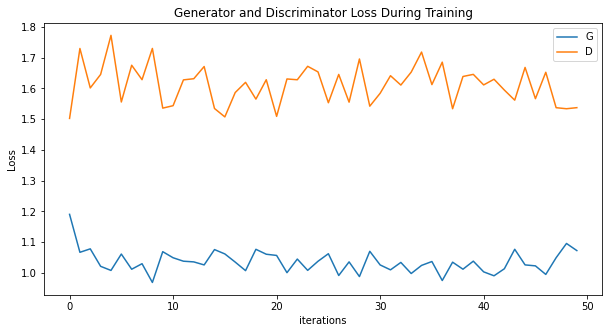

In [83]:
# Loss performance over iterations
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label = "G")
plt.plot(D_losses,label = "D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

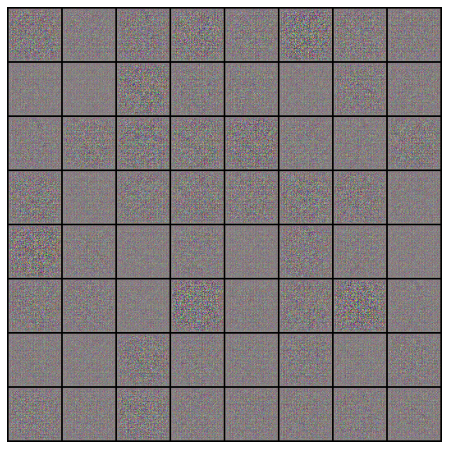

In [84]:
# Visualization of G's progression
#%%capture
fig = plt.figure(figsize = (8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay = 1000, blit = True)

HTML(ani.to_jshtml())

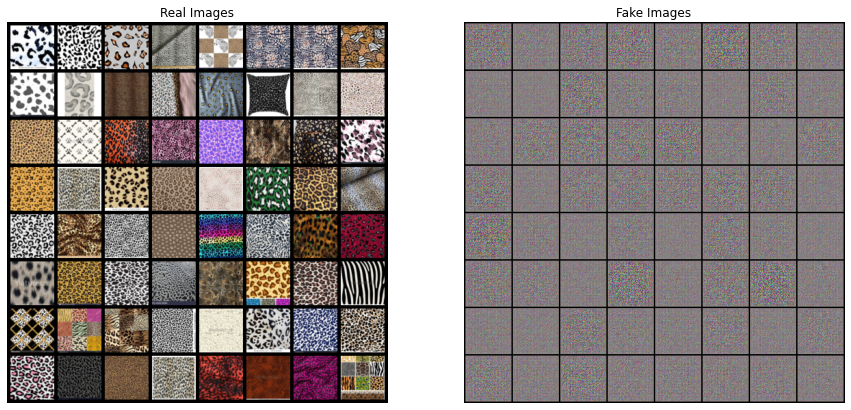

In [85]:
# Real Images vs. Fake Images
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 5, normalize = True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [86]:
# The images that generated from DCGAN model are label as fake. There are 64 image output from the neural network with a size dimension of (64 x 64) color type
print("Size of a particular output: ", fake[2].size())

print("Total number of model output: ", len(fake))

# The image data type is tensor. You can do a simple check below to look at the image in tensor format
fake[2]

Size of a particular output:  torch.Size([3, 64, 64])
Total number of model output:  64


tensor([[[ 0.0104, -0.0482,  0.1299,  ..., -0.0259,  0.1324, -0.0299],
         [ 0.0118,  0.1094,  0.1082,  ..., -0.0787,  0.1606,  0.1055],
         [ 0.1530, -0.0622,  0.0994,  ..., -0.1130,  0.1036,  0.0406],
         ...,
         [ 0.0509,  0.2448, -0.1251,  ...,  0.1612,  0.1341,  0.2141],
         [ 0.0509,  0.1144,  0.0625,  ..., -0.0892,  0.0463,  0.1047],
         [-0.0465,  0.0543,  0.0669,  ...,  0.0423,  0.0514,  0.0241]],

        [[-0.0021,  0.0820, -0.0777,  ...,  0.1640, -0.0243, -0.0399],
         [-0.0691, -0.1068, -0.2004,  ..., -0.0759, -0.0369, -0.0397],
         [ 0.0351, -0.2155, -0.0978,  ..., -0.0009, -0.1804, -0.0392],
         ...,
         [-0.0745, -0.0173, -0.0235,  ...,  0.0740,  0.0925,  0.0698],
         [ 0.0235,  0.0513,  0.0374,  ..., -0.0894, -0.1057,  0.0832],
         [ 0.0064,  0.0058, -0.0520,  ..., -0.0024,  0.0133, -0.0016]],

        [[-0.0018,  0.0568,  0.0038,  ...,  0.0173,  0.0169, -0.1249],
         [ 0.0552, -0.0119,  0.1614,  ...,  0

In [87]:
# This is a function to save all these 64 output images from the DCGAN model
# Depend on your set up Google Drive or local machine, you can update the path location according to your need

def save_fake_images(fabric):
  path_location = "/content/drive/My Drive/Neural Network Art/Data/Component 1 Outputs/" + fabric + "/"

  for i in range(len(fake)):
    file_name = path_location + fabric + "_result_" + str(i) + ".png"
    save_image(fake[i], file_name, normalize = True)

In [88]:
# Call function to save

fabric = "Cheetah"        # depend on your type of fabric (Cheetah, Floral, etc.), you can update accordingly to your need
save_fake_images(fabric)